# ZymoBiomics Community Standard 
## Reference-free analysis
#### Data analysis process
1. process the barcode group fastq files with Kraken2/Bracken
2. filtere the result
3. compaire the result with reference based method
4. combine by species for assembly



In [78]:
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import os
from matplotlib.colors import LogNorm, Normalize

## kraken profiling using PlusPF DB
#### Load the valid barcode filtered by read count

In [5]:
exp_dir = '/drive4/xiangpeng/Project/bacteria/Zymo_novoseq4/split/'
valid_bars =  pd.read_csv(exp_dir + "valid_barcodes.txt", names=['bar'])['bar'].tolist()
print("Started with {} barcode groups".format(len(valid_bars)))

Started with 14175 barcode groups


In [22]:
# process the valid barcodes with Kraken
fq_dir = '/drive4/xiangpeng/Project/bacteria/Zymo_novoseq4/split/scFASTQ/fq/'
kraken_db = '/drive1/xiangpeng/reference/kraken2/plusPF'
kraken_dir = '/drive4/xiangpeng/Project/bacteria/Zymo_novoseq4/split/scFASTQ/kraken/'
output_dir = '/drive4/xiangpeng/Project/bacteria/Zymo_novoseq4/split/scFASTQ/analysis/'
bar_uncls = {}# dictionary of barcode: ratio of unmapped reads

for bar in valid_bars:
    fq1 = fq_dir + bar + '_R1.fq'
    fq2 = fq_dir + bar + '_R2.fq'
    rpt = kraken_dir + bar + '.kraken'
    outpt = kraken_dir + bar + '.output'
    #command for the kraken2 analysis of each barcodes
    kraken_cmd =  'kraken2  --threads 32 --memory-mapping  --db {} --report {} --output {} --paired {} {}'.format(kraken_db,
                                                                                                                  rpt, 
                                                                                                                  outpt,
                                                                                                                  fq1,
                                                                                                                  fq2
        
                                                                                                                )
    #os.system(kraken_cmd)
    # read the first line of the report and get the unmapped read ratio
    rpt_file = open(rpt, "r")
    first_line = rpt_file.readline()
    rpt_file.close()
    uncls_rate = float(first_line.split('\t')[0].strip(' '))
    bar_uncls[bar]=uncls_rate

  

In [38]:
bar_uncls_df = pd.DataFrame.from_dict(bar_uncls,columns=['unclassified_ratio'], orient='index')

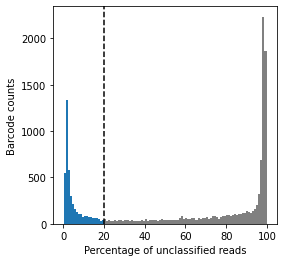

In [134]:
# filter data by unclassified ratio
max_unmap = 20 # select the barcode groups with maxmum 20% read that are not mapped
data = bar_uncls_df['unclassified_ratio'].tolist()

fig, ax = plt.subplots(figsize=(4,4))
N,bins,patches = ax.hist(data, 
                         #edgecolor = 'white', 
                         #linewidth =1,
                         bins =100)
plt.axvline(x=max_unmap, color='k', 
            linestyle='--', 
            label='Cell Threshold')

for i in range(max_unmap,100):    
    patches[i].set_facecolor('grey')
plt.xlabel('Percentage of unclassified reads')#, fontsize=16)
plt.ylabel('Barcode counts')#, fontsize=16)
#plt.title('Perentage of reads not classified by Kraken', fontsize = 16)
plt.savefig(output_dir+'zymo_filter_by_kraken_ummap_rate.pdf')
plt.show()

In [135]:
filtered_bars =  bar_uncls_df[bar_uncls_df['unclassified_ratio']<=max_unmap].index.tolist()
print(len(filtered_bars))

4211


In [136]:
# bracken analysis of the kraken output files with filtered barcodes. 
bar_gns_abd =  pd.DataFrame() # Dataframe of the genus abundace of each barcode group

for bar in filtered_bars:
    # bracken process the kraken output data
    rpt = kraken_dir + bar + '.kraken'
    brk = kraken_dir + bar + '_G.bracken' # bracken output file at Genus level
    brk_cmd =  'bracken -d {} -l G -i {} -o {}'.format(kraken_db,rpt,brk)
    #print(brk_cmd)
    #os.system(brk_cmd)
    
    # read the bracke output file and combine into a dataframe
    try:
        df = pd.read_csv(brk, sep = '\t', index_col = 0) # read the bracken output into a pd dataframe.
        df = df.rename(columns = {'fraction_total_reads': bar})
        bar_gns_abd = pd.concat([bar_gns_abd, df[bar]], axis =1)
    except FileNotFoundError:
        continue
bar_gns_abd = bar_gns_abd.fillna(0)

In [137]:
bar_gns = bar_gns_abd.T
bar_gns.to_csv(output_dir + 'Zymo_filtered_barcode_kraken_genus_abundance.csv')

In [138]:
column_ls = bar_gns.columns.to_list()
bar_gns['purity']=bar_gns[column_ls].max(axis=1)
bar_gns['Genus']=bar_gns[column_ls].idxmax(axis=1)
bar_gns

,Enterococcus,Bacillus,Sediminibacillus,Escherichia,Staphylococcus,Burkholderia,Cryptococcus,Pseudomonas,Bordetella,Thauera,...,Aquicella,Lacunisphaera,Roseivirga,Sulfurimonas,Pontibacter,Thermoanaerosceptrum,Halapricum,Paraurantiacibacter,purity,Genus
CGGATTCTCGCCTGCATC-1,0.96102,0.00593,0.00593,0.02669,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.96102,Enterococcus
GATAACGTCAGCATTCCA-1,0.00175,0.00204,0.00000,0.00000,0.98817,0.00803,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.98817,Staphylococcus
TTAACGTTCACTGGTCAG-1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.98836,0.01164,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.98836,Cryptococcus
TCGGATGTTTTAAGTGGT-1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.29155,0.02075,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.64193,Sphingomonas
ACCTGTACCAGATGAGAT-1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.59219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.59219,Thauera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGTTCTATCCACGCGTAA-2,0.00349,0.00452,0.00000,0.00000,0.00239,0.00000,0.00017,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.98620,Limosilactobacillus
CATCAATAGGTGTCGAGC-2,0.98256,0.00000,0.00000,0.00000,0.01231,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.98256,Enterococcus
CAAGTCGAACCAATGCCT-2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,1.00000,Azoarcus
CCTTGCTTGTGAACCAAT-2,0.00443,0.00566,0.00000,0.00000,0.00479,0.00000,0.00075,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0003,0.95000,Limosilactobacillus


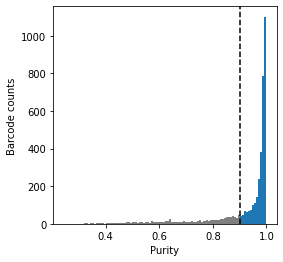

In [139]:
min_purity =0.9

fig, ax = plt.subplots(figsize=(4,4))
plt.axvline(x=min_purity, color='k', linestyle='--', label='Cell Threshold')
n, bins, patches = plt.hist(bar_gns['purity'], bins=100)
for c,p in zip(bins, patches):
    if c < min_purity:
        plt.setp(p, 'facecolor', 'grey')

plt.xlabel('Purity')#, fontsize=16)
plt.ylabel('Barcode counts')#, fontsize=16)
#plt.title('Perentage of reads not classified by Kraken', fontsize = 16)
plt.savefig(output_dir+'Zymo_filter_genuse_level_purity.pdf')

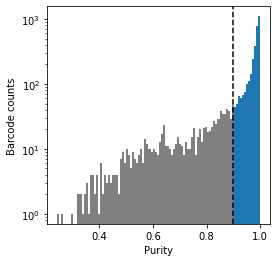

In [140]:
fig, ax = plt.subplots(figsize=(4,4))
plt.axvline(x=min_purity, color='k', linestyle='--', label='Cell Threshold')
n, bins, patches = plt.hist(bar_gns['purity'], bins=100)
for c,p in zip(bins, patches):
    if c < min_purity:
        plt.setp(p, 'facecolor', 'grey')

plt.xlabel('Purity')#, fontsize=16)
plt.ylabel('Barcode counts')#, fontsize=16)
plt.yscale('log')
#plt.title('Perentage of reads not classified by Kraken', fontsize = 16)
plt.savefig(output_dir+'Zymo_filter_genuse_level_purity_log.pdf')

In [141]:
# filtere the data by purity 
bar_gns_filtered = bar_gns[bar_gns['purity']>=min_purity]

### UMAP visulization

In [142]:
adata =  anndata.AnnData(bar_gns_filtered[column_ls], dtype='float64' )

In [143]:
sc.pp.neighbors(adata, use_rep='X')
sc.tl.leiden(adata, resolution=1)

In [144]:
sc.tl.umap(adata)

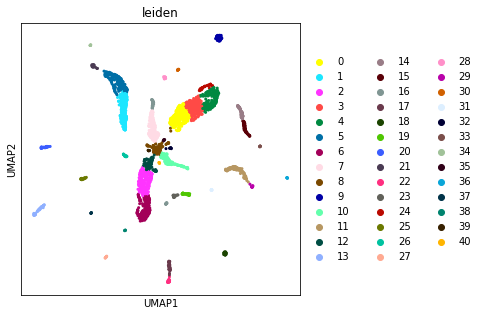

In [145]:
#sc.pl.umap(adata_s, color='leiden')

from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color='leiden')

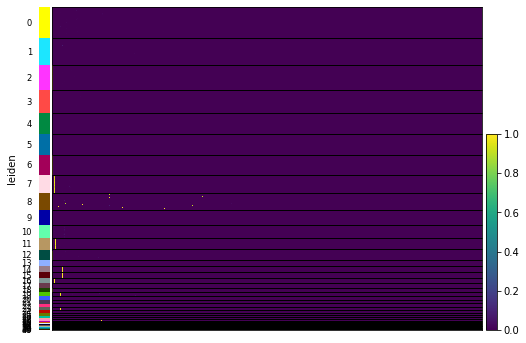

In [146]:
ax = sc.pl.heatmap(adata, 
                   adata.var_names, 
                   groupby='leiden', 
                   cmap='viridis', 
                   dendrogram=False, 
                  )

In [147]:
# assign taxa by the most abundant genus
dic_bar_genera = bar_gns_filtered['Genus'].to_dict()
gns_cnt =  bar_gns_filtered['Genus'].value_counts().to_dict()
for bar in dic_bar_genera:
    genus = dic_bar_genera[bar] 
    if gns_cnt[genus] <=10: # because the list is too long, if the appearace of genus is less than 10 barcodes, then assign it as other
        dic_bar_genera[bar] = 'other'
        
adata.obs['genus']=adata.obs.index.map(dic_bar_genera).astype('category')

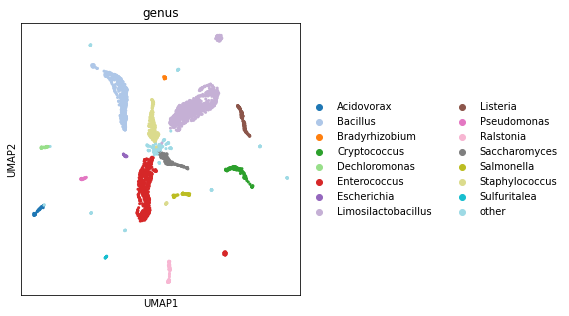

In [148]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color='genus',palette = 'tab20')

In [151]:
### Add taxa infor from reference based analysis
ref_dir = '/drive4/xiangpeng/Project/bacteria/Zymo_novoseq4/split/scFASTQ/ref_analysis/'
ref_file =  ref_dir + 'Zymo_barcode_read_count_mapped_to_species_filtered.csv'
ref_bar_genus_dict = pd.read_csv(ref_file, index_col =0)['Species'].to_dict()

In [152]:
        
adata.obs['genus_input']=adata.obs.index.map(ref_bar_genus_dict).astype('category')

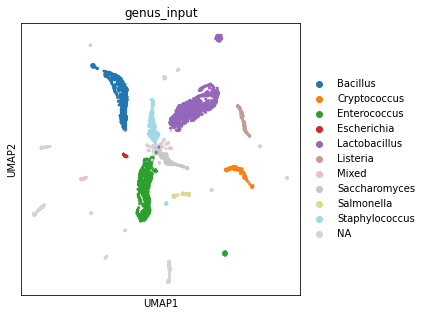

In [153]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color='genus_input',palette = 'tab20')

In [159]:
# compare the kraken based taxa assignment vs reference based methods
k_vs_ref = adata.obs[['genus','genus_input']]

In [163]:
k_vs_ref = k_vs_ref.groupby(['genus','genus_input']).size().reset_index().rename(columns={0:'count'})

In [165]:
k_vs_ref = k_vs_ref[k_vs_ref['count']>0]

In [174]:
k_vs_ref_pivot = k_vs_ref.pivot(index='genus',
              columns = 'genus_input',
               values = 'count',
              )
k_vs_ref_pivot = k_vs_ref_pivot.fillna(0.1)

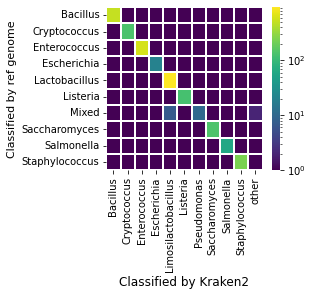

In [176]:
fig, ax = plt.subplots()                                       
fig.set_size_inches(3.5,3) 
#log_norm = LogNorm(vmin=0.01, vmax=1000)
sns.heatmap(k_vs_ref_pivot.T,
            linewidths =0.01,
            norm=LogNorm(vmin = 1, vmax =k_vs_ref_pivot.max().max()),
            cmap='viridis', 
           )
plt.xlabel('Classified by Kraken2',fontsize = 12)
plt.ylabel('Classified by ref genome',fontsize = 11)
plt.show()

In [178]:
adata.write(output_dir + 'Zymo_kraken_anndata.h5ad')